In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Generate fake regression dataset with multiple features
np.random.seed(42)
torch.manual_seed(42)

In [2]:
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
sns.set_style("whitegrid")

### Artificial Dataset

In [4]:
num_samples = 1000
num_features = 3

In [5]:
X = np.random.uniform(0, 20, size=(num_samples, num_features))
y = 2 * X[:, 0] + 0.5 * X[:, 1] ** 2 - X[:, 2] + np.random.normal(0, 1, size=num_samples)


In [6]:
# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Scale features to a small range (0, 1)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

### Loss Functions

In [10]:
class ModifiedMSELoss1(nn.Module):
    def __init__(self):
        super(ModifiedMSELoss1, self).__init__()
    
    def forward(self, y_pred, y_true):
        loss = torch.mean(torch.where(y_pred-y_true > 0, ((y_pred-y_true)**2)*2.0, ((y_pred-y_true)**2)*0.1))
        return loss

In [11]:
class ModifiedMSELoss2(nn.Module):
    def __init__(self):
        super(ModifiedMSELoss2, self).__init__()
    
    def forward(self, y_pred, y_true):
        loss = torch.mean(torch.where(y_pred-y_true > 0, ((y_pred-y_true)**2)*0.1, ((y_pred-y_true)**2)*2.0))
        return loss

In [12]:
loss_1 = ModifiedMSELoss1()
loss_2 = ModifiedMSELoss2()
mse = nn.MSELoss()

In [13]:
def linear_add(y_pred, y_true, weight1, weight2):
    loss1 = loss_1(y_pred, y_true)
    loss2 = loss_2(y_pred, y_true)
    return weight1*loss1 + weight2*loss2, loss1, loss2

In [14]:
def evaluate_model(model, X_eval, y_eval):
    model.eval()
    with torch.no_grad():
        inp = torch.from_numpy(X_eval).float().to(device)
        target = torch.from_numpy(y_eval).float().unsqueeze(1).to(device)
        out = model(inp)
        loss1 = loss_1(out, target).item()
        loss2 = loss_2(out, target).item()
        mse_loss = mse(out, target).item()
        print(f"Loss 1 = {loss1}")
        print(f"Loss 2 = {loss2}")
        print(f"MSE loss = {mse_loss}")
    model.train()
    return loss1, loss2, mse_loss

Linear combination

In [18]:
def train_model(X_train, y_train, weight1, weight2, num_epochs=1000, batch_size = 64):
    model = RegressionModel(num_features).to(device)
    optimizer_wt = optim.Adam(model.parameters(), lr=3e-4)

    num_batches = len(X_train) // batch_size

    total_loss_history = []
    loss_1_history = []
    loss_2_history = []

    for epoch in range(num_epochs):
        epoch_total_loss = 0.0
        epoch_loss1 = 0.0
        epoch_loss2 = 0.0

        # Shuffle the training data
        indices = np.random.permutation(len(X_train))
        X_train = X_train[indices]
        y_train = y_train[indices]

        for batch in range(num_batches):
            start_idx = batch * batch_size
            end_idx = (batch + 1) * batch_size
            
            inputs = torch.from_numpy(X_train[start_idx:end_idx]).float().to(device)
            labels = torch.from_numpy(y_train[start_idx:end_idx]).float().unsqueeze(1).to(device)

            optimizer_wt.zero_grad()

            outputs = model(inputs)
            batch_loss, loss1, loss2 = linear_add(outputs, labels, weight1, weight2)

            batch_loss.backward()
            optimizer_wt.step()

            epoch_total_loss += batch_loss.item()
            epoch_loss1 += loss1.item()
            epoch_loss2 += loss2.item()


        total_loss_history.append(epoch_total_loss / num_batches)
        loss_1_history.append(epoch_loss1 / num_batches)
        loss_2_history.append(epoch_loss2 / num_batches)

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss_history[-1]:.4f}, loss 1: {loss_1_history[-1]:.4f}, loss 2: {loss_2_history[-1]:.4f}")
    
    return model, total_loss_history, loss_1_history, loss_2_history

In [19]:
scaling_coeffs = [0.2, 0.5, 1.0, 2.0, 4.0]

In [20]:
model_dict = {}
for scaling_coeff in scaling_coeffs:
    print(f'Training for scaling coefficient = {scaling_coeff}')
    model, total_loss_history, loss_1_history, loss_2_history = train_model(X_train, y_train, 
                                                                          weight1=1, 
                                                                          weight2=scaling_coeff, 
                                                                          num_epochs=1000,
                                                                          batch_size=64)
    test_loss1, test_loss2, test_mse_loss = evaluate_model(model, X_test, y_test)
    model_dict[scaling_coeff] = {'Model': model,
                          'total_loss_history': total_loss_history,
                          'loss_1_history': loss_1_history,
                          'loss_2_history': loss_2_history,
                          'test_loss1': test_loss1,
                          'test_loss2': test_loss2,
                          'test_mse_loss': test_mse_loss}
    print("\n")

Training for scaling coefficient = 0.2
Epoch 100/1000, Loss: 29.2564, loss 1: 11.8465, loss 2: 87.0491
Epoch 200/1000, Loss: 4.5190, loss 1: 2.2803, loss 2: 11.1935
Epoch 300/1000, Loss: 2.3239, loss 1: 1.2475, loss 2: 5.3817
Epoch 400/1000, Loss: 1.4270, loss 1: 0.6933, loss 2: 3.6684
Epoch 500/1000, Loss: 1.2469, loss 1: 0.6396, loss 2: 3.0367
Epoch 600/1000, Loss: 1.0465, loss 1: 0.5150, loss 2: 2.6574
Epoch 700/1000, Loss: 1.1277, loss 1: 0.5133, loss 2: 3.0716
Epoch 800/1000, Loss: 1.1007, loss 1: 0.5250, loss 2: 2.8786
Epoch 900/1000, Loss: 0.9776, loss 1: 0.4650, loss 2: 2.5628
Epoch 1000/1000, Loss: 0.9502, loss 1: 0.4643, loss 2: 2.4293
Loss 1 = 0.6177160739898682
Loss 2 = 3.1511738300323486
MSE loss = 1.7947094440460205


Training for scaling coefficient = 0.5
Epoch 100/1000, Loss: 103.9519, loss 1: 38.9766, loss 2: 129.9506
Epoch 200/1000, Loss: 15.8301, loss 1: 6.7502, loss 2: 18.1599
Epoch 300/1000, Loss: 8.2258, loss 1: 3.3856, loss 2: 9.6804
Epoch 400/1000, Loss: 5.5477,

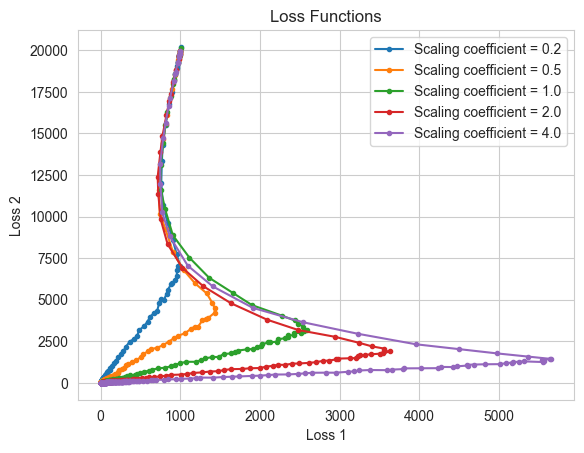

In [21]:
for scaling_coeff in scaling_coeffs:
    label = f'Scaling coefficient = {scaling_coeff}'
    plt.plot(model_dict[scaling_coeff]['loss_1_history'], model_dict[scaling_coeff]['loss_2_history'],
             marker='o', markersize=3, label=label)

plt.xlabel('Loss 1')
plt.ylabel('Loss 2')
plt.title('Loss Functions')

plt.legend()
plt.show()

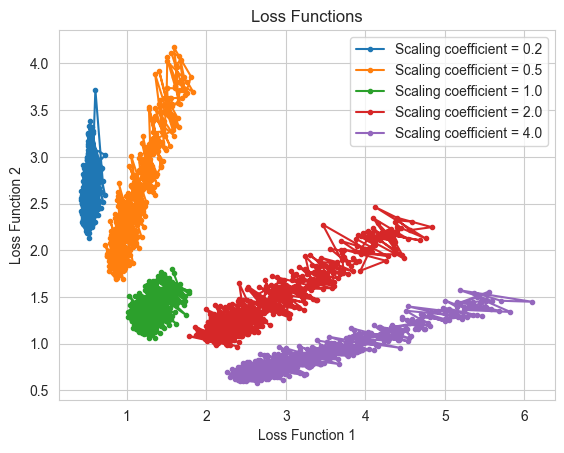

In [22]:
# Plotting for last 500 epochs
for scaling_coeff in scaling_coeffs:
    label = f'Scaling coefficient = {scaling_coeff}'
    plt.plot(model_dict[scaling_coeff]['loss_1_history'][500:], model_dict[scaling_coeff]['loss_2_history'][500:],
             marker='o', markersize=3, label=label)

plt.xlabel('Loss Function 1')
plt.ylabel('Loss Function 2')
plt.title('Loss Functions')

plt.legend()
plt.show()

MDMM

In [23]:
def mdmm(y_pred, y_true, l_multiplier, epsilon, damping):
    loss1 = loss_1(y_pred, y_true)
    loss2 = loss_2(y_pred, y_true)
    infeasibility = loss2 - epsilon
    l_term = l_multiplier * infeasibility
    damp = damping * (infeasibility**2 / 2)
    return loss1 + l_term + damp, loss1, loss2

In [24]:
def train_model_mdmm(X_train, y_train, epsilon, damping, num_epochs=1000, batch_size = 64):
    model = RegressionModel(num_features).to(device)
    l_multiplier = nn.Parameter((torch.tensor(0, dtype=torch.float32, device=device)))

    optimizer_wt = optim.Adam(model.parameters(), lr=3e-4)
    optimizer_l = optim.Adam([l_multiplier], maximize=True, lr=0.005)

    num_batches = len(X_train) // batch_size

    total_loss_history = []
    loss_1_history = []
    loss_2_history = []

    for epoch in range(num_epochs):
        epoch_total_loss = 0.0
        epoch_loss1 = 0.0
        epoch_loss2 = 0.0

        # Shuffle the training data
        indices = np.random.permutation(len(X_train))
        X_train = X_train[indices]
        y_train = y_train[indices]

        for batch in range(num_batches):
            start_idx = batch * batch_size
            end_idx = (batch + 1) * batch_size
            
            inputs = torch.from_numpy(X_train[start_idx:end_idx]).float().to(device)
            labels = torch.from_numpy(y_train[start_idx:end_idx]).float().unsqueeze(1).to(device)

            optimizer_wt.zero_grad()
            optimizer_l.zero_grad()
            
            outputs = model(inputs)
            batch_loss, loss1, loss2 = mdmm(outputs, labels, l_multiplier, epsilon, damping)

            batch_loss.backward()
            optimizer_wt.step()
            optimizer_l.step()

            l_multiplier.data = torch.clamp(l_multiplier.data, min=0.0)

            epoch_total_loss += batch_loss.item()
            epoch_loss1 += loss1.item()
            epoch_loss2 += loss2.item()


        total_loss_history.append(epoch_total_loss / num_batches)
        loss_1_history.append(epoch_loss1 / num_batches)
        loss_2_history.append(epoch_loss2 / num_batches)

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss_history[-1]:.4f}, loss 1: {loss_1_history[-1]:.4f}, loss 2: {loss_2_history[-1]:.4f}")
    
    return model, total_loss_history, loss_1_history, loss_2_history

In [25]:
epsilons = [0.75, 0.8, 1.0, 1.25, 1.5]

In [26]:
model_mdmm_dict = {}
for epsilon in epsilons:
    print(f'Training for epsilon = {epsilon}')
    model, total_loss_history, loss_1_history, loss_2_history = train_model_mdmm(X_train, y_train, 
                                                                          epsilon=epsilon, 
                                                                          damping=0.9, 
                                                                          num_epochs=4000,
                                                                          batch_size=64)
    test_loss1, test_loss2, test_mse_loss = evaluate_model(model, X_test, y_test)
    model_mdmm_dict[epsilon] = {'Model': model,
                          'total_loss_history': total_loss_history,
                          'loss_1_history': loss_1_history,
                          'loss_2_history': loss_2_history,
                          'test_loss1': test_loss1,
                          'test_loss2': test_loss2,
                          'test_mse_loss': test_mse_loss}
    print("\n")

Training for epsilon = 0.75
Epoch 100/4000, Loss: 284452.2383, loss 1: 8827.3010, loss 2: 768.8360
Epoch 200/4000, Loss: 27758.7570, loss 1: 2292.8298, loss 2: 228.2197
Epoch 300/4000, Loss: 6528.5951, loss 1: 1006.3265, loss 2: 105.3135
Epoch 400/4000, Loss: 4659.0623, loss 1: 973.9173, loss 2: 86.0734
Epoch 500/4000, Loss: 3883.9449, loss 1: 943.0379, loss 2: 75.8325
Epoch 600/4000, Loss: 3433.1911, loss 1: 939.9263, loss 2: 69.3297
Epoch 700/4000, Loss: 2751.0784, loss 1: 744.1051, loss 2: 59.5585
Epoch 800/4000, Loss: 2137.7713, loss 1: 654.4268, loss 2: 48.7217
Epoch 900/4000, Loss: 1693.8169, loss 1: 484.5031, loss 2: 40.4444
Epoch 1000/4000, Loss: 1193.5649, loss 1: 343.4275, loss 2: 29.7336
Epoch 1100/4000, Loss: 688.3550, loss 1: 196.0160, loss 2: 18.5123
Epoch 1200/4000, Loss: 345.5312, loss 1: 91.3333, loss 2: 10.2086
Epoch 1300/4000, Loss: 169.8680, loss 1: 50.8818, loss 2: 5.1691
Epoch 1400/4000, Loss: 95.2810, loss 1: 33.4768, loss 2: 2.9719
Epoch 1500/4000, Loss: 54.8604

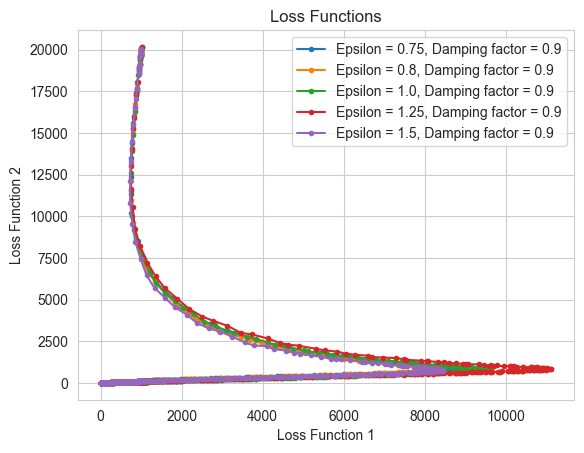

In [27]:
for epsilon in epsilons:
    label = f'Epsilon = {epsilon}, Damping factor = 0.9'
    plt.plot(model_mdmm_dict[epsilon]['loss_1_history'], model_mdmm_dict[epsilon]['loss_2_history'],
             marker='o', markersize=3, label=label)

plt.xlabel('Loss Function 1')
plt.ylabel('Loss Function 2')
plt.title('Loss Functions')

plt.legend()
plt.show()

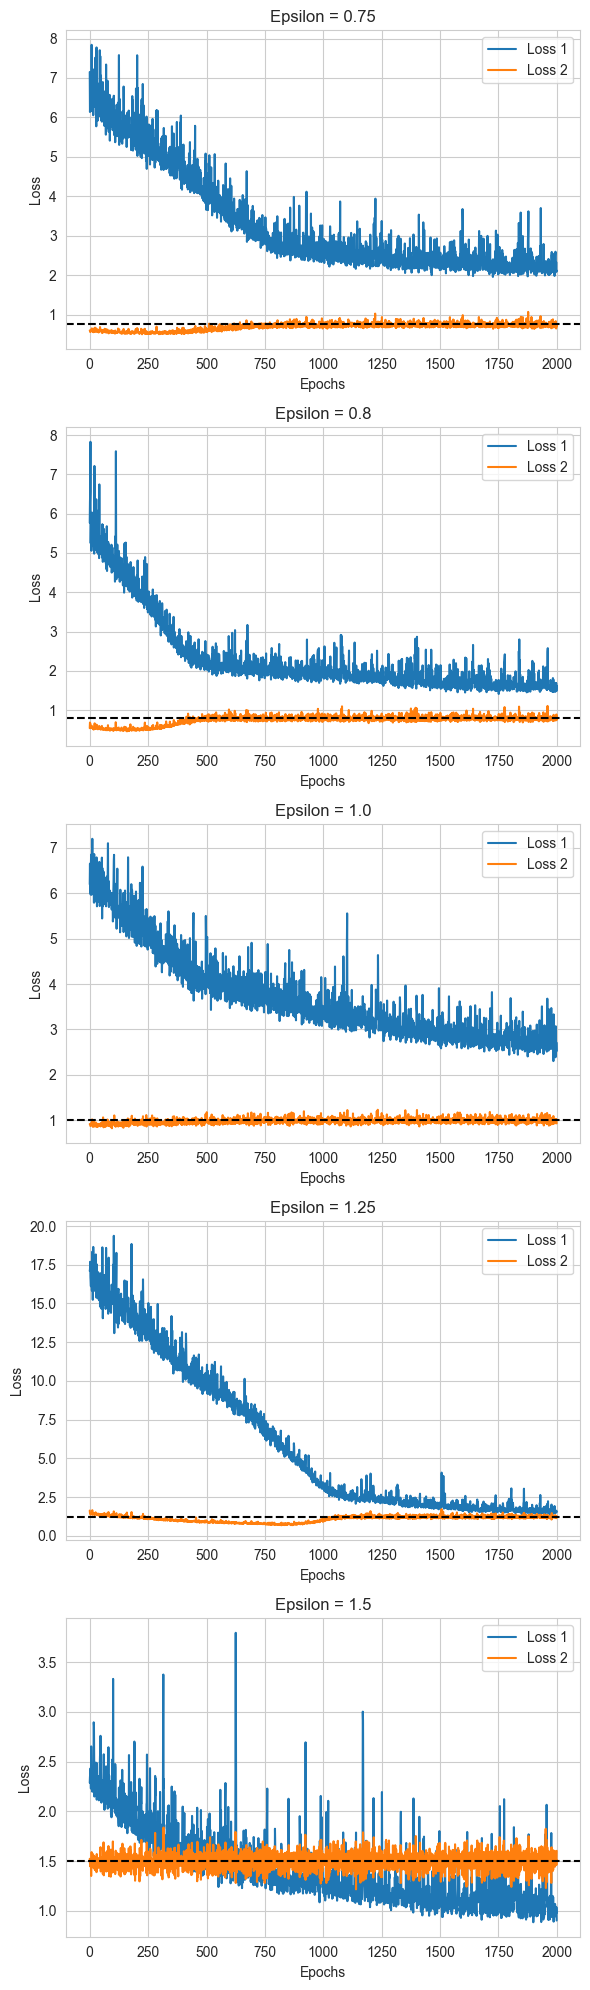

In [28]:
# Plotting for last 2000 epochs
# Create subplots
fig, axs = plt.subplots(5, 1, figsize=(6, 4 * 5))

for i, epsilon in enumerate(epsilons):
    axs[i].plot(model_mdmm_dict[epsilon]['loss_1_history'][2000:], label='Loss 1')
    axs[i].plot(model_mdmm_dict[epsilon]['loss_2_history'][2000:], label='Loss 2')
    axs[i].axhline(epsilon, linestyle='--', color='black')

    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'Epsilon = {epsilon}')
    axs[i].legend()

plt.tight_layout()
plt.show()